In [1]:
! pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 132 kB 25.4 MB/s 
     |████████████████████████████████| 462 kB 48.8 MB/s 
     |████████████████████████████████| 3.8 MB 30.9 MB/s 
     |████████████████████████████████| 14.8 MB 32.2 MB/s 
     |████████████████████████████████| 2.9 MB 33.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68713 sha256=857d8cdd7b8d75faf60a00381cd39cfdcd082c2b28139ca5256933edd00c181a
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

In [1]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta
from tensorflow.keras.callbacks import LearningRateScheduler
import os

In [25]:
theSEED = 232323
tf.random.set_seed(theSEED)
np.random.seed(theSEED)

In [22]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 10       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!mkdir -p '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
!gdown --id '14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7' -O '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip'

In [ ]:
!unzip '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip' -d '/content/gdrive/MyDrive/Curso-Jetson/imagenes/'

In [6]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits'

Test  Training


In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training'

Banana	Lemon  Orange  Strawberry


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 1953 files belonging to 4 classes.
Using 1563 files for training.
Found 1953 files belonging to 4 classes.
Using 390 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

In [ ]:
def process(image,label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
# Create a pretrained model.
base_model = tf.keras.applications.MobileNetV2(
  input_tensor=None, include_top=False, 
  weights='imagenet', input_shape=(224,224,3), classes=4)
base_model.trainable = True
model = tf.keras.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(101, activation='softmax'))
model.build((None, 224,224,3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 320)               409920    
_________________________________________________________________
dropout_8 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 320)              

In [20]:
model.layers[1].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/10
49/49 [==============================] - 32s 529ms/step - loss: 3.9911 - accuracy: 0.1491 - val_loss: 3.0779 - val_accuracy: 0.3641
Epoch 2/10
49/49 [==============================] - 24s 470ms/step - loss: 2.3591 - accuracy: 0.6431 - val_loss: 1.3429 - val_accuracy: 0.8154
Epoch 3/10
49/49 [==============================] - 24s 466ms/step - loss: 0.7874 - accuracy: 0.9566 - val_loss: 0.8493 - val_accuracy: 0.9256
Epoch 4/10
49/49 [==============================] - 24s 469ms/step - loss: 0.3066 - accuracy: 0.9905 - val_loss: 0.6732 - val_accuracy: 0.9128
Epoch 5/10
49/49 [==============================] - 24s 470ms/step - loss: 0.1634 - accuracy: 0.9936 - val_loss: 0.6140 - val_accuracy: 0.8949
Epoch 6/10
49/49 [==============================] - 24s 468ms/step - loss: 0.1209 - accuracy: 0.9973 - val_loss: 0.5526 - val_accuracy: 0.9077
Epoch 7/10
49/49 [==============================] - 24s 466ms/step - loss: 0.0845 - accuracy: 0.9987 - val_loss: 0.5446 - val_accuracy: 0.8846

In [28]:
model.evaluate(val_ds)

13/13 [==============================] - 2s 121ms/step - loss: 0.5056 - accuracy: 0.9077


[0.5055843591690063, 0.9076923131942749]

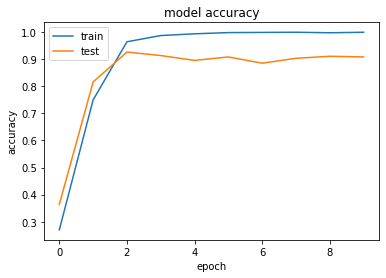

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

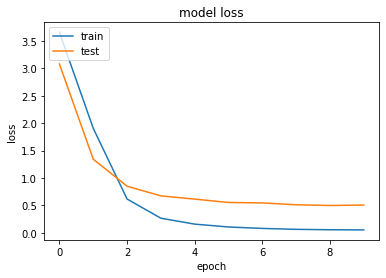

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-pract2'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-pract2/assets


In [35]:
!ls $OUT_MODEL_PATH

model-final-pract1	 model-final-pract2
model-final-pract1.hdf5  model-final-pract2.hdf5
